# Data Mining - Handin 3 - Pattern mining

This handin corresponds to the topics in Week 15--18 of the course.

The handin is
* done in groups
* worth 10% of the grade

For the handin, you will prepare a report in PDF format, by exporting the Jupyter notebook. Please submit the following no later than **May 16th 23:59 CET**.
1. The Jupyter notebook file with your answers
2. The PDF obtained by exporting the Jupyter notebook

**The grading system**: Tasks are assigned a number of points based on the difficulty and time to solve it. The sum of the number of points is **70**. For the maximum grade you need to get at least _63 points_. The minimum grade (02 in the Danish scale) requires **at least** 21 points, with at least 8 points from Parts 1 and 2, and 5 points from Part 3. Good luck!

**The exercise types**: There are five different types of exercises
1. <span style='color: green'>**\[Compute by hand\]**</span> means that you should provide NO code, but show the main steps to reach the result (not all). 
2. <span style='color: green'>**\[Motivate\]**</span> means to provide a short answer of 1-2 lines indicating the main reasoning, e.g., the PageRank of a complete graph is 1/n in all nodes as all nodes are symmetric and are connected one another.
3. <span style='color: green'>**\[Describe\]**</span> means to provide a potentially longer answer of 1-5 lines indicating the analysis of the data and the results.
4. <span style='color: green'>**\[Prove\]**</span> means to provide a formal argument and NO code.
5. <span style='color: green'>**\[Implement\]**</span> means to provide an implementation. Unless otherwise specified, you are allowed to use helper functions (e.g., ```np.mean```, ```itertools.combinations```, and so on). However, if the task is to implement an algorithm, by no means a call to a library that implements the same algorithm will be deemed as sufficient!

**Q&A**

Q: If the task is to implement a mean function, may I just call ```np.mean()```? 
<br>A: No.

Q: If the task is to compare the mean of X and Y, may I use ```np.mean()``` to calculate the mean?
<br>A: Yes.

Q: If I have implemented a mean function in a previous task, but I am unsure of its correctness, may I use ```np.mean()``` in following task where mean is used as a helper function? 
<br>A: Yes.

Q: May I use ```np.mean()``` to debug my implementation of mean?
<br>A: Yes.

Q: Do I get 0 points for a task if I skip it?
<br>A: Yes.

Q: Can I get partial points for a task I did partially correct?
<br>A: Yes.

Q: Is it OK to skip a task if I do not need the points from it?
<br>A: Yes.

Q: Should I inform a TA if I find an error?
<br>A: Yes.

Q: Should I ask questions if I am confused?
<br>A: Yes.



Good luck!

<span style="color:red">New packages have been added to "requirements.yml". To install them, go to the root of the repository and run:
```
conda activate dm25
conda env update -f requirements.yml --prune
```
</span>



In [ ]:
conda env update -f /workspaces/dm2025-exercises/requirements.yml --prune

In [ ]:
pip install tabulate

In [ ]:
### BEGIN IMPORTS - DO NOT TOUCH!

import itertools
from itertools import combinations

import importlib
import pandas as pd
import numpy as np
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import tabulate
from tqdm import tqdm
import time

import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from scipy import sparse
import faiss
import unicodedata

from datasets import load_dataset
from utilities.load_data import load_market_basket
from beir import util
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.custom_metrics import top_k_accuracy

import sys
sys.path.append('../utilities')
#from load_data import load_dblp_citations

### END IMPORTS - DO NOT TOUCH!

# Part 1: Subgraph mining (25 Points)
In this part, we will work with subgraph mining algorithms. We will first solve some theory exercises and then implement two simple algorithms. 

## Task 1.1 DFS codes (13 Points)

### Task 1.1.1 (6 Points)
<span style='color: green'>**\[Compute by hand\]**</span> Find the canonical (i.e., minimal) DFS code for the graph below. Try to eliminate some codes without generating the complete search tree. *Hint*: you can eliminate a code if you can show that it will have a larger code than some other code (e.g., using label ordering, degree). 

<div>
<img src="data/dfs-codes.png" width="300">
</div>

*******************
<span style="color:red">**YOUR ANSWER HERE**</span>
******************

To find the canonical DFS code for the given graph, we need to consider all possible DFS traversals and select the lexicographically smallest one. The graph has nodes labeled A, B, C with edges (A,B) and (B,C).

The DFS codes will be:

    Start at A: (A,B,0,1,A,B), (B,C,1,2,B,C)
    Start at B: (B,A,0,1,B,A), (B,C,0,2,B,C)
    Start at C: (C,B,0,1,C,B), (B,A,1,2,B,A)

The lexicographically smallest one is:
(0,1,0,1,A,B), (1,2,1,2,B,C)

### Task 1.1.2 (4 Points)
<span style='color: green'>**\[Describe\]**</span> an extension to the DFS-code notation and the rules for the lexicographic ordering that handles the case of *directed* graphs. If that is not possible, state why.

*******************
<span style="color:red">**YOUR ANSWER HERE**</span>
******************

In directed graphs, we need to add edge direction information to the DFS code. Each edge tuple would need an additional field to indicate direction (forward or backward). Lexicographic ordering rules would need to consider:

    Forward edges come before backward edges
    When the directions are equal, apply the same ordering as undirected case
    Node labels still dictate topological ordering

### Task 1.1.3 (3 Points)
 <span style='color: green'>**\[Describe\]**</span> (no need for pseudocode) a suitable way to find the _maximum_ DFS-code from the rules for _minimum_ DFS-codes that you already know from the lecture.

*******************
<span style="color:red">**YOUR ANSWER HERE**</span>
******************
In order to calculate the maximum DFS-code, we can use the same regulations as for minimum DFS-codes but reverse the ordering criteria:

    Larger node labels is the first preference
    For identical labels, favor backward edges over forward edges
    For identical edge types, favor larger discovery times

## Task 1.2 Maximum Independent Set (12 Points)

### Task 1.2.1 (6 Points)
<span style='color: green'>**\[Prove\]**</span>  Sketch a proof that the Maximum Independent Set (MIS) support is anti-monotone, i.e., the support of a pattern $P'$ is no larger than _any_ pattern $P$ included in $P'$ (that is, $P$ is a sub-pattern of $P'$). To guide you into the proof, start from a set of matchings of the pattern $P'$ which corresponds to an independent set of nodes $I'$ in the overlap graph $G'_{O}$, same for the set of nodes $I$ in the overlap graph $G_O$ of $P$. Observe (_Observation 1_) that the **all** the matchings $f'$ of $P'$ contain matchings $f$ of $P$. Also observe (_Observation 2_) that if you take two matchings $f_1'$ and $f_2'$ of $P'$ and the corresponding matchings $f_1$ and $f_2$ of $P$ overlap, so do the matchings $f_1'$ and $f_2'$. Given these two observation what can you deduce on the independent sets $I'$ of $G'_O$ and $I$ of $G_O$?

*******************
<span style="color:red">**YOUR ANSWER HERE**</span>
******************
For pattern P' with P:

    Each matching of P' has a matching of P (Observation 1)
    Two overlapping matchings of P' are equivalent to two overlapping matchings of P (Observation 2)
    Therefore, each independent set in G'O corresponds to an independent set in GO
    Max independent set of G'O cannot exceed that of GO

Thus, support(P') ≤ support(P)

### Task 1.2.2 (6 Points)

<span style='color: green'>**\[Implement\]**</span> In this exercise, you will program a simplified version of the Maximum Independent Set (MIS) support. Your exercise is to construct an algorithm that takes as input a pattern $P$ and the matches of the pattern in the graph $G$, and finds the Maximum Independent Set (MIS) support. Since finding the MIS is NP-hard, your exercise is to implement a simple greedy approximation algorithm. To test the code, you can use the graph and code below. 

In [11]:
def mis_support(P, matches): 
    """
    Returns the MIS support of a pattern. 

    Parameters
    ----------
    P:       The pattern represented as a networkx undirected graph object
    matches: A list of subgraph isomorphic matches. Each match is a dictionary id_node_pattern -> id_node_graph
    """
    mis = 0
    ### YOUR CODE HERE
    if not matches:
        return 0
    
    # overlap graph
    overlap_graph = nx.Graph()
    overlap_graph.add_nodes_from(range(len(matches)))
    
    # edges between overlapping matches
    for i, j in combinations(range(len(matches)), 2):
        # if matchings i and j overlap
        node_i = set(matches[i].values())
        node_j = set(matches[j].values())
        if node_i & node_j:
            overlap_graph.add_edge(i, j)

    remaining_nodes = set(overlap_graph.nodes())
    
    while remaining_nodes:
        # Select node with minimum degree
        node = min(remaining_nodes, key=lambda x: overlap_graph.degree(x))
        mis += 1
        # Remove selected node and its neighbors
        neighbors = set(overlap_graph.neighbors(node)) | {node}
        remaining_nodes -= neighbors

    ### YOUR CODE HERE
    return mis

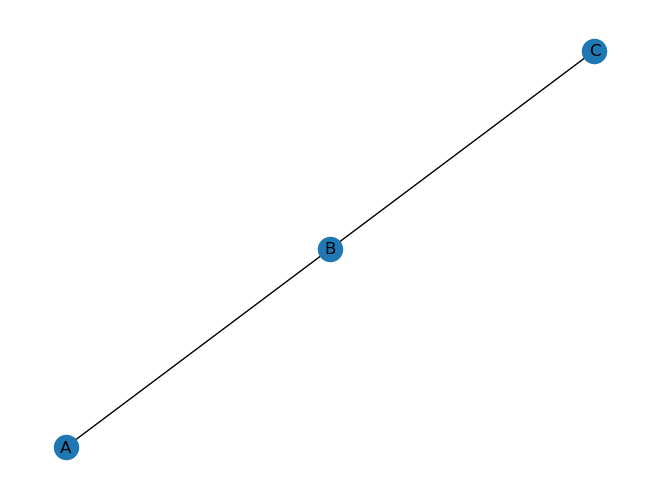

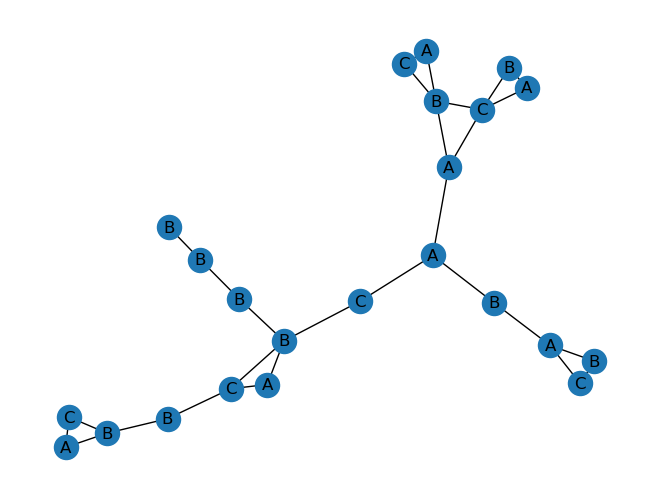

{1: 1, 2: 2, 3: 3}
{1: 1, 2: 2, 5: 3}
{8: 1, 9: 2, 10: 3}
{11: 1, 12: 2, 10: 3}
{11: 1, 12: 2, 13: 3}
{14: 1, 12: 2, 13: 3}
{14: 1, 12: 2, 10: 3}
{17: 1, 16: 2, 15: 3}
{21: 1, 19: 2, 20: 3}
The MIS support for pattern [1, 2, 3] in G is: 1.000000


In [12]:
from networkx.algorithms import isomorphism

# Example pattern
P = nx.Graph()
P.add_nodes_from([(1,{"label":"A"}), (2,{"label":"B"}), (3,{"label":"C"})])
P.add_edges_from([(1,2),(2,3)])
labels = nx.get_node_attributes(P, 'label') 
plt.figure(1)
nx.draw(P,labels=labels)

# Example graph
G = nx.read_gml("data/graph.gml", label='id')
labels = nx.get_node_attributes(G, 'label') 
pos = nx.spring_layout(G)
plt.figure(2)
nx.draw(G,pos, labels=labels)

plt.show()

# Find the matches of P in G
nm = isomorphism.GraphMatcher(G,P,node_match=isomorphism.categorical_node_match("label", "A"))
matches = []
for subgraph in nm.subgraph_monomorphisms_iter():
    matches.append(subgraph)
    print(subgraph)
    
print("The MIS support for pattern %s in G is: %f" %(P.nodes, mis_support(P, matches)))


In [ ]:
### EXTRA CODE BLOCK HERE

*******************
<span style="color:red">**YOUR ANSWER HERE**</span>
******************

# Part 2: Frequent itemsets (25 Points)
We have learned the Apriori and FP-Growth algorithms for mining frequent itemsets. In this part, we will implement these algorithms and compare their performance.

We will use the anonymized real-world Kosarak clickstream dataset from: http://fimi.ua.ac.be/data/.
This dataset was collected from a Hungarian online news portal, where each transaction represents a single user session (i.e., the list of pages a user visited). It contains approximately 990,000 transactions and over 41,000 unique items. 

You may work with the top-50 most frequent items to reduce runtime and improve clarity.
_Hint:_ Each transaction contains a space-separated list of integer item IDs.

After running the code block below, the variable **kosarak_small** will contain the filtered transactions with top-50 frequent items.

In [ ]:
from utilities.load_data import load_market_basket

def filter_transactions(T, k=50):
    """
    Keep only the top k items in the transactions.
    Remove transactions that become empty.
    """
    # Find the max item ID dynamically
    max_item_id = max(i for t in T for i in t) + 1
    counts = [0] * max_item_id

    for t in T:
        for i in t:
            counts[i] += 1

    # Sort and select top k
    counts = np.array(counts)
    order  = np.argsort(counts)[::-1] # reverse the sorted order

    indexes_to_keep = order[:k]  # Keep the top k items
    index_set = set(indexes_to_keep)   # Convert to python set for efficiency

    # Filter transactions
    T_new = [t_ for t_ in [list(filter(lambda i: i in index_set, t)) for t in T] if t_]
    return T_new


kosarak = load_market_basket()
kosarak_small = filter_transactions(kosarak)


## Task 2.1 Association Rules (4 Points)
Consider the following table

| Transaction ID | Items              |
|----------------|--------------------|
| 1              | Ape, Cat, Dog, Cow |
| 2              | Cat, Dog, Pig, Cow |
| 3              | Dog, Bat, Pig, Cow |
| 4              | Dog, Pig, Cow      |
| 5              | Dog, Cow           |
| 6              | Cat, Cow           |
| 7              | Ape, Bat, Fox      |
| 8              | Ape, Cow           |
| 9              | Ape, Dog, Cow      |


### Task 2.1.1 (0.5 Points)
<span style='color: green'>**\[Motivate\]**</span> What is the count of the itemset {Dog,Pig,Cow} ?

*******************
<span style="color:red">**YOUR ANSWER HERE**</span>
******************
The itemset {Dog,Pig,Cow} appears in transactions 2, 3, and 4. so, 3 times.

### Task 2.1.2 (0.5 Points)
<span style='color: green'>**\[Compute by hand\]**</span> What is the support and confidence of the association rule {Dog,Pig}->Cow ?

*******************
<span style="color:red">**YOUR ANSWER HERE**</span>
******************

Support = support({Dog,Pig,Cow}) / total transactions = 3/9 = 1/3

Confidence = support({Dog,Pig,Cow}) / support({Dog,Pig}) = 3/4

### Task 2.1.3 (1.5 Point)
<span style='color: green'>**\[Compute by hand\]**</span> Consider the application of the Apriori algorithm to find all the frequent itemsets
whose counts are at least 3.

*******************
<span style="color:red">**YOUR ANSWER HERE**</span>
******************

1. itemsets:
{Ape}: 3, {Cat}: 3, {Dog}: 6, {Cow}: 7, {Pig}: 3

2. itemsets:
{Dog,Cow}: 5, {Cat,Cow}: 2, {Pig,Cow}: 3, {Dog,Pig}: 3

3. itemsets:
{Dog,Pig,Cow}: 3

### Task 2.1.4 (1.5 Point)
<span style='color: green'>**\[Compute by hand\]**</span> Find all the association rules with support at least 1/3 and confidence at least 1/2.


*******************
<span style="color:red">**YOUR ANSWER HERE**</span>
******************

1.     {Dog,Pig}->Cow: support=1/3, confidence=3/4

2.     {Pig}->Cow: support=1/3, confidence=1

3.     {Dog}->Cow: support=5/9, confidence=5/6

4.     {Dog,Cow}->Pig: support=1/3, confidence=3/5

## Task 2.2 A Priori algorithm (9 Points)

### Task 2.2.1 (7 Points)
<span style='color: green'>**\[Implement\]**</span> Develop an implementation of the Apriori algorithm. You can look at your implementation from the exercises (note that this one is slightly different to simplify comparison with FP-Growth).

In [16]:
def apriori_algorithm(T, min_support=10):
    """
        Apriori algorithm for mining frequent itemsets and association rules. 
        This implementation should just find frequent itemsets, and ignore the rule generation.
        Inputs:
            T:               A list of lists, each inner list will contiain integer-item-ids. 
                             Example: T = [[1, 2, 5], [2, 3, 4], [1, 6]]
            min_support:     int: The total number of occurences needed for an itemset to be considered frequent
        
        Outputs:
            itemsets:        Dictionary of with keys as frequent itemset, and value as the total count of this itemset 
    """
    itemsets = dict()
    ### TODO Your code here
    
    # Get all unique items
    unique_items = set(item for transaction in T for item in transaction)
    
    # Generate 1-itemsets
    C1 = {frozenset([item]): sum(1 for t in T if item in t) for item in unique_items}
    L1 = {k: v for k, v in C1.items() if v >= min_support}
    itemsets[1] = L1
    
    k = 2
    while True:
        # Generate candidates
        Ck = compute_candidates(itemsets[k-1].keys())
        
        # Count support for candidates
        Ck_counts = {}
        for candidate in Ck:
            count = 0
            for t in T:
                if candidate.issubset(t):
                    count += 1
            if count >= min_support:
                Ck_counts[candidate] = count
        
        if not Ck_counts:
            break
            
        itemsets[k] = Ck_counts
        k += 1
    
    # Flatten itemsets
    all_itemsets = {}
    for length in itemsets:
        for itemset in itemsets[length]:
            all_itemsets[tuple(sorted(itemset))] = itemsets[length][itemset]
    itemset = all_itemsets
    ### TODO Your code here
    return itemsets

def compute_candidates(prev_itemset):
    Ck = set()
    # Join step
    for itemset in prev_itemset:
        its1 = tuple(sorted(itemset))
        for itemset2 in prev_itemset:
            its2 = tuple(sorted(itemset2))
            if its1[:-1] == its2[:-1]:
                if its1[-1] < its2[-1]: Ck.add(its1 + its2[-1:])

    # Pruning step
    to_remove = set()
    for c in Ck:
        for subset in combinations(c, len(c)-1):
            if not subset in prev_itemset:
                to_remove.add(c)
                break
    for c in to_remove:
        Ck.remove(c)
    
    return Ck

In [ ]:
# Test 1: Simple test case with small dataset
def test_apriori_small():
    transactions = [
        ['A', 'B', 'C'],
        ['A', 'B'],
        ['A', 'C'],
        ['A'],
        ['B', 'C'],
        ['B'],
        ['C']
    ]
    
    print("Testing with small dataset:")
    print("Transactions:", transactions)
    
    # Test with min_support=2
    result = apriori_algorithm(transactions, min_support=2)
    print("\nResults (min_support=2):")
    for itemset, count in sorted(result.items()):
        print(f"{itemset}: {count}")
    
    # Expected output:
    # ('A',): 4
    # ('A', 'B'): 2
    # ('A', 'C'): 2
    # ('B',): 4
    # ('B', 'C'): 2
    # ('C',): 4
    
    # Test with min_support=3
    result = apriori_algorithm(transactions, min_support=3)
    print("\nResults (min_support=3):")
    for itemset, count in sorted(result.items()):
        print(f"{itemset}: {count}")
    
    # Expected output:
    # ('A',): 4
    # ('B',): 4
    # ('C',): 4

# Test 2: Test with kosarak_small dataset
def test_apriori_kosarak():
    print("\nTesting with kosarak_small dataset (min_support=10):")
    result = apriori_algorithm(kosarak_small, min_support=10)
    
    # Print statistics
    print(f"Found {len(result)} frequent itemsets")
    
    # Group by itemset length
    length_counts = {}
    for itemset in result:
        length = len(itemset)
        length_counts[length] = length_counts.get(length, 0) + 1
    
    print("\nItemsets by length:")
    for length, count in sorted(length_counts.items()):
        print(f"{length}-itemsets: {count}")
    
    # Print some examples
    print("\nSample frequent itemsets:")
    for length in sorted(length_counts.keys()):
        examples = [itemset for itemset in result if len(itemset) == length][:3]
        print(f"{length}-itemsets examples: {examples}")

# Test 3: Edge cases
def test_apriori_edge_cases():
    print("\nTesting edge cases:")
    
    # Empty transactions
    print("\nCase 1: Empty transactions list")
    result = apriori_algorithm([], min_support=1)
    print("Result:", result)  # Expected: {}
    
    # Single transaction
    print("\nCase 2: Single transaction")
    result = apriori_algorithm([['A', 'B']], min_support=1)
    print("Result:", result)  # Expected: {('A',): 1, ('B',): 1, ('A', 'B'): 1}
    
    # No frequent itemsets
    print("\nCase 3: No items meet min_support")
    result = apriori_algorithm([['A'], ['B']], min_support=2)
    print("Result:", result)  # Expected: {}

# Run all tests
if __name__ == "__main__":
    test_apriori_small()
    test_apriori_kosarak()
    test_apriori_edge_cases()

### Task 2.2.2 (2 Points)
<span style='color: green'>**\[Implement\]**</span> Run Apriori on the data-set (using the **kosarak** variable and **not kosarak_small**). Try a few different values of min_support. </br>
<span style='color: green'>**\[Motivate\]**</span> Roughly how large does `min_support` need to be before no itemsets of size 2 are found? (Note that you don't need to find the exact value; reporting `min_support` to the nearest 1000 will suffice).

Note that the dataset is reasonably large, so this **can take up a large amount of time depending on your value of min support and implementation.**

In [ ]:
### YOUR CODE HERE
def estimate():
    supports = [1000, 5000, 10000, 20000, 30000, 40000, 50000]
    
    for s in supports:
        print(f"Testing min_support = {s}")
        result = apriori_algorithm(kosarak, min_support=s)
        has_pairs = any(len(itemset) == 2 for itemset in result)
        print(f"Found 2-itemsets: {has_pairs}")
        if not has_pairs:
            print(f"No 2-itemsets found at min_support = {s}")
            return s
    
    print("Try higher support values")
    return None

estimate()

******************
<span style="color:red">**YOUR ANSWER HERE**</span>
******************

## Task 2.3 FP-Growth (9 Points)

### Task 2.3.1 (7 Points)
<span style='color: green'>**\[Implement\]**</span> Complete the implementation of FP-Growth below. You only need to implement growing the tree and building the header table. It is clearly marked where you need to implement.

In [ ]:
class FP_Tree:
    def __init__(self, T, min_support=10):
        """
        Constructor for FP_Tree. Should correctly build an FP-Tree with header table.
        Hint: I strongly advise you to implement the missing sections of the Node class before this one
        
        Inputs:
            T:               A list of lists, each inner list will contiain integer-item-ids. 
                             Example: T = [[1, 2, 5], [2, 3, 4], [1, 6]]
            min_support:     The total number of occurences needed to keep the itemset.
        """
        self.min_support    = min_support
        self.header_table   = {}
        self.root           = Node(header_table = self.header_table)
        
        ### YOUR CODE HERE

         
        # count item frequencies
        item_counts = {}
        for t in T:
            for item in t:
                item_counts[item] = item_counts.get(item, 0) + 1
        
        #  items below min_support and sort
        frequent_items = {k: v for k, v in item_counts.items() if v >= min_support}
        sorted_items = sorted(frequent_items.items(), key=lambda x: (-x[1], x[0]))
        
        # headr table
        for item, count in sorted_items:
            self.header_table[item] = {'count': count, 'nodelink': None}
        
        # Build tree
        for t in T:
            # Filtre and sort transaction items
            filtered = [item for item in t if item in frequent_items]
            filtered.sort(key=lambda x: (-frequent_items[x], x))
            
            current_node = self.root
            for item in filtered:
                if item in current_node.children:
                    current_node = current_node.children[item]
                    current_node.count += 1
                else:
                    new_node = Node(header_table=self.header_table, 
                                  value=item, parent=current_node)
                    current_node.children[item] = new_node
                    current_node = new_node
                    
                    # Update header table nodelink
                    if self.header_table[item]['nodelink'] is None:
                        self.header_table[item]['nodelink'] = current_node
                    else:
                        node = self.header_table[item]['nodelink']
                        while node.nodelink is not None:
                            node = node.nodelink
                        node.nodelink = current_node
        
        ### YOUR CODE HERE
    
    
    ### Common functions for FP-tree and Conditional FP-tree
    ### You do not need to modify the rest of this class
    def generate_pattern(self, keys, support):
        return tuple(keys + self.get_suffix()), support
    
    def get_suffix(self):
        return []
    
    # This is the main function for generating frequent itemsets. You do not need to modify this,
    # but I recommend reading and trying to understand it.
    def mine_frequent_itemsets(self, res=None):
        if res is None: res = []
        
        if self.root.is_single_path():
            keys = list(self.header_table.keys())
            key_idx = {k:i for i, k in enumerate(keys)}
            counts = [self.header_table[k].count for k in keys]
            
            for key_pair in itertools.chain(*[itertools.combinations(keys, k) for k in range(1, len(keys)+1)]):
                support = min([counts[key_idx[k]] for k in key_pair])
                if support >= self.min_support: 
                    res.append(self.generate_pattern(list(key_pair), support))
         
        else: # Not single path
            for key, node in self.header_table.items():
                support = node.support()
                
                if support >= self.min_support:
                    res.append( self.generate_pattern([key], support) )
                
                basis = []
                while node is not None:
                    curr_node = node
                    node = node.nodelink
                    
                    if curr_node.parent is None:  continue
                        
                    path = curr_node.path(limit=curr_node.count)[:-1]
                    if len(path) == 0:  continue
                        
                    basis.append( path )
                    
                if len(basis) == 0: continue
                    
                conditional_tree = Conditional_FP_Tree(self.min_support, [key] + self.get_suffix(), basis)
                if conditional_tree.root is None: continue
                    
                conditional_tree.mine_frequent_itemsets(res=res)
        return res


# You don't need to modify anything in this class
class Conditional_FP_Tree(FP_Tree):
    def __init__(self, min_support, suffix, basis): 
        self.min_support    = min_support
        self.suffix         = suffix
        self.header_table   = {} # This will hold all unique items
        
        self.root           = Node(header_table=self.header_table)
        
        self.build_tree(basis)
        # self.root           = prune(self.root, min_support)
        if self.root is None: print("WARNING: root is empty after pruning")
        
    def build_tree(self, basis):
        for b in basis:
            count = b[0][1]
            path = list(map(lambda x: x[0], b))
            for i in range(count):
                self.root.add_path(path)
    
    def get_suffix(self):
        return self.suffix

class Node:
    def __init__(self, header_table, value=None, parent=None, path=None):
        """
        Constructor for Node class, which is used for the FP-Tree. 
        Inputs:
            header_table:    Dict. Should be same dict for all nodes in the tree
            value:           Integer id of the item the node represents
            parent:          Parent Node. None if root node
            path:            List of node values for a path that should start in this node.
        """
        
        self.children     = {}
        self.header_table = header_table 
        self.nodelink     = None
        self.value        = None
        self.parent       = None
        self.count        = 0
        
        if value is not None: # Only root node should have None as value
            self.value          = value
            self.parent         = parent
            # YOUR CODE HERE

            # YOUR CODE HERE
        
        if path is not None: 
            self.add_path(path)
            
    
    def add_path(self, path):
        """
        Function for adding a path to tree. 
        Should follow an existing path and increment count while such a path exists. 
        If no path exists (or only partial path exists), this function should create or complete such a path
        Hint: Recursion might be helpful.
        Inputs:
            path:            A list node values. 
                             Example: path = [1, 2, 5]
        """
        
        ### YOUR CODE HERE
        
        ### YOUR CODE HERE
    
    
    # Functions for frequent items-sets and rule mining below. You do not need to modify these
    def is_single_path(self):
        if   len(self.children) == 0: return True 
        elif len(self.children) >  1: return False
        else:  # len == 1
            key = next((k for k in self.children.keys()))
            return self.children[key].is_single_path()
    
    def support(self, verbose=False):
        if verbose: print("Counting support, this value is ", self.value, " with count ", self.count, " and parent ", self.parent.value)
            
        if self.nodelink is not None: return self.count + self.nodelink.support(verbose)
        else:                         return self.count
    
    def path(self, limit=-1):
        if self.value is None: 
            return []
        else:                  
            count = self.count if limit == -1 else min(self.count, limit)
            return self.parent.path(limit=limit) + [(self.value, count)]
    
    def print(self, indent="", spacing="----|-"):
        print(indent + str(self.value) + ":" + str(self.count))
        for v in self.children.values():
            v.print(indent=indent + spacing)
            



In [ ]:
### YOUR TEST CODE HERE

### Task 2.3.2 (2 Points)
<span style='color: green'>**\[Implement\]**</span> Run FP-Growth on the data-set (using the **kosarak** variable and **not kosarak_small**). Try a few different values of min_support. </br>
<span style='color: green'>**\[Motivate\]**</span> Roughly how large does `min_support` need to be before all itemsets of size 1 and 2 are found but no itemsets of size 3? (Note that you don't need to find the exact value; reporting `min_support` to the nearest 1000 will suffice).

Note that the dataset is reasonably large, so this **can take up a large amount of time depending on your value of min support and implementation.**

In [ ]:
### YOUR CODE HERE
fp_tree = FP_Tree(kosarak, 30000)
freq1 = fp_tree.mine_frequent_itemsets()
print(freq1)

## Task 2.4 Comparing A priori and FP-Growth (3 Points)
Run the given experiment and show to what extent FP-Growth has an advantage.   
<span style='color: green'>**\[Describe\]**</span> Comment on the results. What do you see? What did you expect to see?

In [ ]:
# Script for testing the runtime of your algorithms. 
# WARNING: This will take a reasonably long time to run.
    
def sample(n=200, alphabet_size=5):
    candidates  = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])[:alphabet_size]
    m = candidates.shape[0]
    
    T = []
    for i in range(n):
        size = int(np.random.rand() * (m)) + 1
        T.append(list(candidates[np.random.permutation(m)[:size]]))
        
    return T

def test():
    # If you want to test it quickly, you can modify "transaction_lengths" and "alphabet_sizes" temporarily. 
    # This will give you errors in the plotting (next code cell) though.
    # Make sure you use the original values for "transaction_lengths" and "alphabet_sizes" for your final version.
    transaction_lengths = [2**i for i in range(4, 11)]
    alphabet_sizes      = [3, 6, 9, 12] 
    
    min_support = 10
    repeats     = 10
    
    stop = False
    results = np.zeros((len(transaction_lengths), len(alphabet_sizes), 2))
    stderrs = np.zeros((len(transaction_lengths), len(alphabet_sizes), 2))
    
#     print(results.shape)
    
    for i, n in enumerate(transaction_lengths):
        for j, a in enumerate(alphabet_sizes):
            print(" - - " * 4, "n=%d,a=%d" % (n, a), " - - " * 4)
            times = []
            for _ in range(repeats):
                T = sample(n, a)

                t0 = time.time()
                tree = FP_Tree(T, min_support=min_support)
                frequent_itemsets = tree.mine_frequent_itemsets()
                t1 = time.time() - t0

                i1 = {tuple(sorted(list(k))): v for k, v in frequent_itemsets}

                t0 = time.time()
                itemsets = apriori_algorithm(T, min_support=min_support)
                t2 = time.time() - t0

                i2 = {}
                for V in itemsets.values():
                    for k, v in V.items():
                        i2[tuple(sorted(list(k)))] = v

                assert len(i1) == len(i2)
                for k in i1.keys():
                    assert i1[k] == i2[k]

                times.append([t1, t2])

            results[i, j] = np.mean(times, axis=0)
            stderrs[i, j] = np.std(times, axis=0)
            print(np.mean(times, axis=0), "+-", np.std(times, axis=0), "\n")
            
    np.save('itemsets_runningtimes', results)  # Results are saved to avoid having to run it again if plot code needs changing
    np.save('itemsets_stderr', stderrs)
    
    return results, stderrs
        
results, stderrs = test()     



In [ ]:
import matplotlib.pyplot as plt

results = np.load('itemsets_runningtimes.npy')
stderrs = np.load('itemsets_stderr.npy')

# Plotting 
transaction_lengths = [2**i for i in range(4, 11)]
alphabet_sizes      = [3, 6, 9, 12] 

n, a, _ = results.shape
res_to_plot = np.transpose(results, (1, 0, 2))
err_to_plot = np.transpose(stderrs, (1, 0, 2))

fig, ax = plt.subplots(1, a, figsize=(4*a, 4))
for i, (res, err) in enumerate(zip(res_to_plot, err_to_plot)):
    ax[i].plot(transaction_lengths, res[:,0], label='FP-Tree', color='C1')
    ax[i].fill_between(transaction_lengths, res[:,0] - err[:,0], res[:,0] + err[:,0], alpha=0.3, linewidth=0 , color='C1')
    
    x = transaction_lengths[-1]
    ax[i].set_xlim((2**4, 2**11))
    ax[i].annotate(text='', xy=(x, res[-1,0]), xytext=(x,res[-1,1]), arrowprops=dict(arrowstyle='|-|'))
    ax[i].annotate(text='%.1f $\\times$'%(res[-1,1]/res[-1,0]), xy=(x-24,  (res[-1,1] / 2 + res[-1,0]/2)), horizontalalignment='right')
    
    ax[i].plot(transaction_lengths, res[:,1], label='Apriori', color='C2')
    ax[i].fill_between(transaction_lengths, res[:,1] - err[:,1], res[:,1] + err[:,1], alpha=0.3, linewidth=0 , color='C2')
    
    ax[i].set_title("Alphabet size: %d" % alphabet_sizes[i])
    ax[i].set_xscale('log', base=2)
    ax[i].legend()
    ax[i].set_xlabel('Number of transactions')
    ax[i].set_ylabel('Seconds')

plt.tight_layout()
    

*******************
<span style="color:red">**YOUR ANSWER HERE**</span>
******************

# Part 3: Text Mining (20 points)

In this section we will work with textual data, more concretely with a subset of the [Wikipedia Dataset](https://huggingface.co/datasets/wikimedia/wikipedia).


Run the code below to download and load the dataset. 

In [18]:
dataset = load_dataset("rudygawron/wikipedia-20220301.simple-processed", data_files="original_text.csv", split="train")
dataset = dataset.to_pandas()
dataset

README.md:   0%|          | 0.00/2.56k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


original_text.csv:   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

,id,url,title,text
0,1,https://simple.wikipedia.org/wiki/April,April,April is the fourth month of the year in the J...
1,2,https://simple.wikipedia.org/wiki/August,August,August (Aug.) is the eighth month of the year ...
2,6,https://simple.wikipedia.org/wiki/Art,Art,Art is a creative activity that expresses imag...
3,8,https://simple.wikipedia.org/wiki/A,A,A or a is the first letter of the English alph...
4,9,https://simple.wikipedia.org/wiki/Air,Air,Air refers to the Earth's atmosphere. Air is a...
...,...,...,...,...
205323,910281,https://simple.wikipedia.org/wiki/Noticiero%20...,Noticiero Univision,Noticiero Univision is the flagship daily even...
205324,910287,https://simple.wikipedia.org/wiki/Bachhan%20Pa...,Bachhan Paandey,Bachchhan Paandey is an upcoming Indian Hindi-...
205325,910294,https://simple.wikipedia.org/wiki/Repdigit,Repdigit,"In recreational math, a repdigit or a monodigi..."
205326,910309,https://simple.wikipedia.org/wiki/Lady%20in%20...,Lady in a Cage,Lady in a Cage is a 1964 American psychologica...


In the following exercises, we will try to embed the text from the dataset and do some document retrieval. Before we can do that, we need to clean the data. As you probably know from the lectures, a typical cleaning procedure involves:
- converting text to UTF-8, e.g, “Cafée” → “Cafee”
- lowercasing
- Stemming or Lemmatization, e.g., “walking”, “walks”, “walked” → “walk”
- stop-word removal e.g., “a”, “the”, “is”, “you”, “I”, punctuation marks

All of that can be done with the function below.

***[Hint]** It will probably be useful in the following exercises. So don't forget about it.*

In [ ]:
spacy_model_name = "en_core_web_sm"
if not importlib.util.find_spec(spacy_model_name):
    spacy.cli.download(spacy_model_name)

nlp = spacy.load("en_core_web_sm", disable=["ner", "textcat"])

In [ ]:
def clean(text: str):
    text = unicodedata.normalize('NFKD', text).encode("ascii", "ignore").decode("utf-8").lower()
    doc = nlp(text)
    return " ".join(token.lemma_ for token in doc if token.is_alpha and not token.is_stop)

clean("Héllo, thé quíck brówn föx jumpéd över thé lazy dög at 21:37!")

In [ ]:
### YOUR TEST CODE HERE

If you’ve tried cleaning the text in the dataset we use, you’ll quickly learn that it takes a lot of time to run. We’ve done this part for you.   
Run the code below to download and load the cleaned Wikipedia dataset. Each row represents a cleaned sentence from the original dataset. The sentences can be grouped into paragraphs (by `paragraph_id`) or articles (by `article_id`).

In [ ]:
# Load the processed Wikipedia dataset from Hugging Face
processed_dataset = load_dataset("rudygawron/wikipedia-20220301.simple-processed", data_files="processed_text.csv", split="train")
wiki_df = processed_dataset.to_pandas()
wiki_df

## Task 3.1 Similar document retrieval (warmup) (5 points)

The goal is as follows. First, we want to convert every article in the dataset into an embedding. Then, given as input a document from the same dataset, we want to be able to retrieve the top-$k$ most similar documents.

### Task 3.1.1 (1 points)

<span style='color: green'>**\[Implement\]**</span> Using Singular Value Decomposition (SVD) compute embeddings of every document in the dataset. <br>

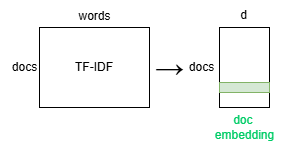

***[Hint]** First you need to merge `processed_text` into articles, then compute BOW matrix, convert it into TF-IDF matrix and after that you compute embeddings using SVD.*<br>
<span style="color:red">**[Note]** In your implementation you should use the imports in the cell below.</span> <br>
<span style="color:red">**[Note]** When using `TruncatedSVD` set `random_state=42` to ensure reproducibility.</span>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

### TODO YOUR CODE BELOW
articles = wiki_df.groupby('article_id')['processed_text'].apply(' '.join).reset_index()

# Create pipeline for TF-IDF and SVD
pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=50, random_state=42))
])

# a numpy matrix of shape (#docs x d) where d is a hyperparameter that you have to choose yourself
# i-th row should correspond to i-th row in `dataset`
document_embeddings = pipeline.fit_transform(articles['processed_text'])

### Task 3.1.2 (3 points)
<span style='color: green'>**\[Describe\]**</span> Why do we need to clean the text before embedding it? Take into consideration the following concepts from the lecture:
- converting text to UTF-8
- lowercasing
- Lemmatization/Stemming
- stop-word removal<br>
- ...

Give at least three arguments to justify your response.


******************
<span style="color:red">**YOUR ANSWER HERE**</span> <br>
******************

### Task 3.1.3 (1 point)

<span style='color: green'>**\[Implement\]**</span> the similar document retrieval function. Given the embedding of a document from the Wikipedia dataset and a parameter $k$, the function should return indices of the $k$ semantically closest articles. You can use either the cosine distance or the L2 distance as a measure of similarity.

You can implement distance calculations yourself, but you have already done it in the previous assignments; that's why, here you can use the FAISS (Facebook AI Similarity Search) library. It's commonly used for efficient similarity search. <br>
It contains two classes that we are interested in:
- `faiss.IndexFlatL2` - for L2 similarity comparison
- `faiss.IndexFlatIP` - for cosine similarity comparison

In [ ]:
def search_similar_docs(query: np.ndarray, k: int, index=None):
    """
    Search for the top `k` most similar documents to the given query.

    Parameters
    ----------
    query : np.ndarray
        The embedding of the query document.
    k : int
        The number of similar documents to retrieve.
    index: 
        The FAISS index containing the document embeddings or just a numpy array with embeddings.

    Returns
    -------
    A list of indices of the `k` closest embedded articles.
    """
    ### TODO YOUR CODE THERE
    query = query.reshape(1, -1).astype('float32')
    distances, indices = index.search(query, k)
    return []

Run the code below to test your implementation.

***[Hint]** If the most similar element to the query isn't the query itself, you've probably made a mistake somewhere.*

In [ ]:
query_doc_index = 1194 # you can try different documents to get a feeling of how it works
result_ids = search_similar_docs(document_embeddings[query_doc_index] , k=10)

similar_titles = dataset.iloc[result_ids]['title'].tolist()
similar_urls = dataset.iloc[result_ids]['url'].tolist()

print("Query Document Title:", dataset.iloc[query_doc_index]['title'])
print("Similar Document Titles and URLs:")
for title, url in zip(similar_titles, similar_urls):
    print(f"- {title}: {url}")

## Task 3.2 Similar document retrieval (the actual exercise) (6 points)

Now you will try a different approach for creating document embeddings. Instead of embedding documents directly using SVD, you will first embed words using SVD. <br>
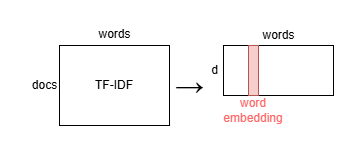 <br>
And then create document embeddings by taking average (or sum) of the embeddings of words present in the document. <br>
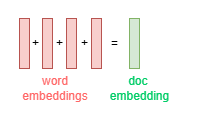 <br>
An advantage of this approach is that, after learning word embeddings on the Wikipedia dataset, you can then create embeddings for any document, even those outside the dataset, and use them for similar document retrieval.

### Task 3.2.1 Implementation (6 points)

<span style='color: green'>**\[Implement\]**</span> the functions in the class below.

A) `train` - As input, takes an array of `texts` and a parameter `d`. First, you need to convert `texts` to a TF-IDF matrix and then create `d`-dimensional word embeddings using SVD. Store the embeddings somehow, you will need them to implement `store` and `retrieve`. You will also need to know which embedding corresponds to which word. If you are using `CountVectorizer()` to create the BOW matrix, you can get the list of words with `get_feature_names_out()`. <br>

B) `store` - As input, takes an array of `docs`. Converts them into `d`-dimensional document embeddings by taking the average of the embeddings of words present in the document. Again, you need to store the embeddings somehow, you will need them in `retrieve`. <br>

C) `retrieve` - As input, takes an array of text `queries` and a parameter `k`. Converts the `queries` into document embeddings. For each `query` in `queries`, returns indices of `k` closest `docs` stored in `store` function. Use **L2 distance** there. Returned `docs` should be ordered from closest to furthest. The returned matrix should have shape (#queries x k).<br>

You can assume that text inputs are already cleaned.

<span style="color:red">**[Note]** When using `TruncatedSVD` set `random_state=42`.</span>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

class DocumentRetrieval():
    def __init__(self):
        self.word_embeddings = None
        self.vocab = None
        self.doc_embeddings = None
        
    def train(self, texts, d: int) -> None:
        # Create TF-IDF matrix
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(texts)
        tfidf = TfidfTransformer().fit_transform(X)
        
        # Get word embeddings with SVD
        svd = TruncatedSVD(n_components=d, random_state=42)
        self.word_embeddings = svd.fit_transform(tfidf.T)
        self.vocab = vectorizer.get_feature_names_out()
        
    def store(self, docs) -> None:
        vectorizer = CountVectorizer(vocabulary=self.vocab)
        X = vectorizer.transform(docs)
        
        # Create document embeddings by averaging word embeddings
        self.doc_embeddings = []
        for doc in X:
            indices = doc.indices
            if len(indices) == 0:
                self.doc_embeddings.append(np.zeros(self.word_embeddings.shape[1]))
                continue
                
            doc_embedding = np.mean(self.word_embeddings[indices], axis=0)
            self.doc_embeddings.append(doc_embedding)
            
        self.doc_embeddings = np.array(self.doc_embeddings)
        
        # Create FAISS index
        self.index = faiss.IndexFlatL2(self.doc_embeddings.shape[1])
        self.index.add(self.doc_embeddings.astype('float32'))
        
    def retrieve(self, queries, k: int) -> np.ndarray:
        # Convert queries to embeddings
        vectorizer = CountVectorizer(vocabulary=self.vocab)
        X = vectorizer.transform(queries)
        
        query_embeddings = []
        for query in X:
            indices = query.indices
            if len(indices) == 0:
                query_embeddings.append(np.zeros(self.word_embeddings.shape[1]))
                continue
                
            query_embedding = np.mean(self.word_embeddings[indices], axis=0)
            query_embeddings.append(query_embedding)
            
        query_embeddings = np.array(query_embeddings).astype('float32')
        
        # Search nearest neighbors
        distances, indices = self.index.search(query_embeddings, k)
        return indices

Now, you will test the performance of your similar document retrieval algorithm on a benchmark. Run the code below to download a dataset you will test your algorithm against.

In [ ]:
from beir import util
from beir.datasets.data_loader import GenericDataLoader

dataset = "scifact"
data_path = util.download_and_unzip(f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset}.zip", "./data")
corpus, queries, qrels = GenericDataLoader(data_path).load(split="test")

`corpus` contains docs that you want to store using `store` and later retrieve using `retrieve`. <br>
`queries` contains queries that you want to pass as argument to `retrieve`. <br>
`qrels` contains ground truth retrieval results used in the benchmark.

Run the code below to clean `corpus` and `queries`. 

In [ ]:
corpus_df = pd.DataFrame.from_dict(corpus, orient='index').reset_index().rename(columns={'index': 'corpus_id'})
corpus_df.reset_index(drop=True, inplace=True)
corpus_df.drop(columns=['title'], inplace=True)
corpus_df['processed_text'] = [clean(text) for text in tqdm(corpus_df['text'])]
corpus_df

In [ ]:
queries_df = pd.DataFrame(list(queries.items()), columns=['query_id', 'query_text'])
queries_df['processed_text'] = [clean(doc) for doc in tqdm(queries.values())]
queries_df

Run the test below that check the accuracy of you algorithm.

In [ ]:
dr = DocumentRetrieval()

# For the training we pass all sentences from Wikipedia dataset
dr.train(wiki_df['processed_text'], d=50)

# store documents from the corpus
dr.store(corpus_df['processed_text'])

# return most similar docs
I = dr.retrieve(queries_df['processed_text'], k=100)

def test(I):
    I_dict = {query_id: {corpus_df.iloc[id]['corpus_id']: -i for i, id in enumerate(I_row)} for query_id, I_row in zip(queries_df['query_id'], I)}
    return top_k_accuracy(qrels, I_dict, [1, 3, 5, 10, 100])

test(I)

## Task 3.3 Upgrading the model (9 points)

Your task is to **introduce, test, and reason** about the result of the following modifications to the algorithm. If some modification results in a better model performance, keep it, so that at the end of the exercise, you end up with the best-performing model. <br>

<span style="color:red">**[Note]** When performing experiments, take into consideration how you present the results, i.e., the aesthetics.</span>

### Task 3.3.1 (3 points)

**A).** <span style='color: green'>**\[Implement\]**</span> Currently in `train`, you use `TfidfTransformer` in order to create a TF-IDF matrix and then perform SVD on it to get word embeddings. Now, instead of using the TF-IDF matrix, you will use the pointwise mutual information (PMI) matrix. Unfortunately, `sklearn` doesn't provide something like `PMITransformer`. But that's not a problem, you are computer scientists, you can implement it yourselves.<br>

**Steps to Implement a PMI Transformer:**
1. In the code below, you can assume that `X` is an output from `CountVectorizer`, which means it is a co-occurrence matrix where rows represent sentences and columns represent words.
2. Estimate probabilities:
   - $ P(c, w) = \frac{X[c, w]}{\sum_{i,j} X[i,j]} $
   - $ P(c) = \frac{\sum_j X[c, j]}{\sum_{i,j} X[i,j]} $
   - $ P(w) = \frac{\sum_i X[i, w]}{\sum_{i,j} X[i,j]} $
3. Compute PMI:
   $\text{PMI}[c, w] = \log \left( \frac{P(c, w)}{P(c)P(w)} \right)$
4. Clip PMI values to 0 to get Positive PMI.

In [ ]:
from scipy import sparse

class PMITransformer:

    def fit(self, X, y=None):
        """
        Fit the PMITransformer to the given co-occurrence matrix.
        """
        if not sparse.issparse(X):
            X = sparse.csr_matrix(X)

        ### TODO YOUR CODE STARTS HERE
        total = X.sum()
        
        # P(w) - probability of word w
        word_sums = np.array(X.sum(axis=0)).flatten()
        self.Pw = word_sums / total
        
        # P(c) - probability of context (document)
        doc_sums = np.array(X.sum(axis=1)).flatten()
        self.Pc = doc_sums / total

        ### TODO YOUR CODE ENDS HERE
        return self


    def transform(self, X):
        """
        Transform the given co-occurrence matrix into a PMI matrix.
        """
        if not sparse.issparse(X):
            X = sparse.csr_matrix(X)

        X_coo = X.tocoo()
        rows, cols = X_coo.row, X_coo.col
        
        ### TODO YOUR CODE STARTS HERE
        total = X.sum()
        Pcw = X_coo.data / total
        
        # PMI calculation
        Pc = self.Pc[rows]
        Pw = self.Pw[cols]
        pmi_data = np.log2(Pcw / (Pc * Pw))
        
        # PPMI (positive PMI)
        pmi_data[pmi_data < 0] = 0
        
        ### TODO YOUR CODE ENDS HERE
        return sparse.coo_matrix((pmi_data, (rows, cols)), shape=X.shape)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)


**B).** <span style='color: green'>**\[Implement & Test\]**</span> Plug `PMITransformer` (which you implemented above) into `DocumentRetrieval` and test the performance.

In [ ]:
### TODO YOUR CODE HERE

**C).** <span style='color: green'>**\[Motivate\]**</span> What do you observe? Justify your answer by reasoning about the results. 

******************
<span style="color:red">**YOUR ANSWER HERE**</span> <br>
******************

### Task 3.3.2 (3 points)

**A).** <span style='color: green'>**\[Implement & Test\]**</span> Currently, you `train` your model by performing SVD on a matrix where each row represents a single sentence. Try: <br>
&emsp;1). grouping sentences into paragraphs (by `paragraph_id`) <br>
&emsp;2). grouping sentences into articles (by `article_id`) <br>
&emsp;3). performing a sliding window on each sentence. Use `step size` = 3 and `window size` = 7.<br>

***[Hint]** Don't know what a sliding window is? Consider the following example.   
Let the input sentence be: "Africa is the world's second-largest and second-most populous continent after Asia".   
After cleaning, it becomes: "africa world second large second populous continent asia".   
After applying a sliding window with `step size` = 2 and `window size` = 3, it becomes: ["africa world second", "second large second", "second populous continent", "continent asia"].*


In [ ]:
### TODO YOUR CODE HERE

# by paragraph
paragraphs = wiki_df.groupby('paragraph_id')['processed_text'].apply(' '.join)

# group by article
articles = wiki_df.groupby('article_id')['processed_text'].apply(' '.join)

def sliding_window(text, window_size=7, step=3):
    words = text.split()
    windows = []
    for i in range(0, len(words) - window_size + 1, step):
        window = ' '.join(words[i:i+window_size])
        windows.append(window)
    return windows

windowed = wiki_df['processed_text'].apply(lambda x: sliding_window(x)).explode()

B). <span style='color: green'>**\[Describe\]**</span> What do you observe? Is this something that you expected? Justify your answer by reasoning about the results.

******************
<span style="color:red">**YOUR ANSWER HERE**</span> <br>
******************

### Task 3.3.3 (3 points)

**A).** <span style='color: green'>**\[Implement & Test\]**</span> Currently you used L2 distance in order to compute document similarities. Try cosine similarity instead. Then run the following experiment. For both L2 and cosine distance, test the performance for different values of word embedding dimensionality `d`. Try `d = 25, 50, 75, 100, 200, 300, 400, and 500` (but it's encouraged to try more if you think it brings some value to the experiment). Plot the results of the top-100 accuracy.

In [ ]:
# WARNING: This will take a reasonably long time to run.
### TODO YOUR CODE HERE
import matplotlib.pyplot as plt

d_values = [25, 50, 75, 100, 200, 300, 400, 500]
l2_accuracies = []
cos_accuracies = []

for d in d_values:
    # L2 distance
    dr = DocumentRetrieval()
    dr.train(wiki_df['processed_text'], d=d)
    dr.store(corpus_df['processed_text'])
    I = dr.retrieve(queries_df['processed_text'], k=100)
    l2_accuracies.append(test(I)[4])  # top-100 accuracy
    
    # Cosine similarity
    dr.index = faiss.IndexFlatIP(dr.doc_embeddings.shape[1])  # Inner product for cosine
    faiss.normalize_L2(dr.doc_embeddings)  # Normalize for cosine similarity
    dr.index.add(dr.doc_embeddings.astype('float32'))
    I = dr.retrieve(queries_df['processed_text'], k=100)
    cos_accuracies.append(test(I)[4])

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(d_values, l2_accuracies, label='L2 Distance')
plt.plot(d_values, cos_accuracies, label='Cosine Similarity')
plt.xlabel('Embedding Dimension (d)')
plt.ylabel('Top-100 Accuracy')
plt.title('Performance Comparison by Distance Metric')
plt.legend()
plt.grid()
plt.show()

B). <span style='color: green'>**\[Describe\]**</span> What do you observe? Is this something that you expected? If yes, why? If no, why not?

******************
<span style="color:red">**YOUR ANSWER HERE**</span> <br>
******************

### Task 3.3.4 (0 points)

Try thinking of other ways to improve the model, implement, and test those ideas. You don't get points for this exercise, but by doing it, you might learn something new. We will, of course, give you feedback for this exercise.